# ***A Content-Based Movie Recommendation System Using MovieLens Small Data (GroupLens)***

# **CAPSTONE PROJECT**

# **Executive Summary**

This project develops and evaluates a movie recommendation system using the MovieLens Small dataset, with the goal of generating personalized movie recommendations based on historical user rating behavior. Exploratory data analysis revealed a highly sparse user–item interaction matrix and uneven user activity, which informed preprocessing decisions and justified the use of collaborative filtering as the primary recommendation approach.

The system was built by constructing a user–item rating matrix and applying cosine similarity to identify movies with similar rating patterns. Qualitative evaluation showed that the system consistently produced coherent and relevant recommendations for both popular and niche movies, indicating that meaningful user preference patterns were successfully captured.

To demonstrate practical applicability, the recommendation logic was deployed through a command-line interface that allows users to input a movie title and receive real-time recommendations. While the system is limited by common collaborative filtering challenges such as cold-start and data sparsity, it provides a complete end-to-end recommendation pipeline and a strong foundation for future enhancements.

This project is fully reproducible and publicly available on GitHub:  
**Repository:** https://github.com/njaunewton/movie-recommendation-system/tree/main

The recommendation system was developed using the MovieLens Latest Small Dataset, provided by GroupLens Research at the University of Minnesota:  
**Dataset Source:** https://files.grouplens.org/datasets/movielens/ml-latest-small.zip



# **1. INTRODUCTION**

Recommendation systems play a central role in modern digital platforms by helping users discover relevant content from large catalogs. In the movie domain, users are often overwhelmed by the number of available options, making personalized recommendations essential for improving user experience. 

In this project, a content-based movie recommendation system was developed using the MovieLens Small dataset. The system recommends movies based on similarity in content features such as genres and user-generated tags. By comparing movies with similar characteristics, the system is able to generate meaningful Top-N recommendations and provide explanations for why each recommendation was made. 


# **2. DATASET DESCRIPTION**

The MovieLens Small dataset was obtained from the GroupLens research group. It contains user ratings and metadata for movies collected from a movie recommendation platform. 

Three files were used in this project: 
    - movies.csv, which contains movie titles and genres 
    - ratings.csv, which records user ratings for movies 
    - tags.csv, which includes user-generated descriptive tags 

This dataset is well-suited for building a recommendation system due to the availability of both user interaction data and rich item-level content features. 

In [3]:
from pathlib import Path

# Dataset storage 

def print_tree(path, prefix=""):
    contents = [item for item in sorted(path.iterdir(), key=lambda x: (x.is_file(), x.name.lower()))
                if not item.name.startswith('.')]
    
    for index, item in enumerate(contents):
        is_last = index == len(contents) - 1
        branch = "└── " if is_last else "├── "
        
        print(prefix + branch + item.name)
        
        if item.is_dir():
            extension = "    " if is_last else "│   "
            print_tree(item, prefix + extension)

# Move one level up to project root
project_root = Path("..").resolve()

print(project_root.name + "/")
print_tree(project_root)


ml-latest-small/
├── data
│   └── raw
│       ├── links.csv
│       ├── movies.csv
│       ├── ratings.csv
│       └── tags.csv
├── notebooks
│   └── Newton_Capstone_Recommendation System.ipynb
├── reports
│   ├── Newton_Capstone_Recommendation System HTML.html
│   └── Newton_Capstone_Recommendation System PDF.pdf
├── src
│   └── movie_recommender_cli.py
└── README.md


In [5]:
#Verify folders structure

import os
print(os.getcwd())



E:\Newton Docs\COLLEGE\CAPSTONE PROJECTS\Month 2\CAPSTONE RECOMMENDATION SYSTEM\ml-latest-small


In [6]:
# Loading libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

print("Libraries imported successfully")


Libraries imported successfully


# **3. DATA LOADING AND EDA**

Exploratory data analysis was conducted to understand the structure, scale, and key characteristics of the MovieLens dataset. The dataset contains thousands of movies and over one hundred thousand user ratings, representing interactions from several hundred users.

Analysis of the rating distribution shows that most ratings fall between 3.0 and 5.0 stars, indicating that users are more likely to rate movies they have enjoyed. Additionally, examination of the user–item interaction matrix reveals a high level of sparsity, as most users have rated only a small fraction of the available movies.

This high sparsity presents challenges for traditional collaborative filtering methods and motivates careful preprocessing and evaluation. These insights inform the selection of appropriate recommendation system techniques in later stages of the project.


## 3.1 Dataset Loading and Shapes

In [7]:

import pandas as pd

movies = pd.read_csv("data/raw/movies.csv")
ratings = pd.read_csv("data/raw/ratings.csv")
tags = pd.read_csv("data/raw/tags.csv")

print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Tags shape:", tags.shape)


Movies shape: (9742, 3)
Ratings shape: (100836, 4)
Tags shape: (3683, 4)


The movies dataset contains several thousand unique movies, each identified by a unique movie identifier and associated metadata such as title and genre.

The ratings dataset is significantly larger, containing over one hundred thousand user–movie interactions. This indicates that users typically rate only a small subset of the available movies, contributing to a sparse user–item interaction matrix.

The tags dataset is comparatively smaller, reflecting the optional nature of user-generated tagging activity.


## 3.2 Preview of the Datasets

In [8]:
dataset_sizes = pd.DataFrame({
    "Dataset": ["Movies", "Ratings", "Tags"],
    "Number of Records": [len(movies), len(ratings), len(tags)]
})

dataset_sizes


,Dataset,Number of Records
0,Movies,9742
1,Ratings,100836
2,Tags,3683


In [9]:
movies.head()
ratings.head()
tags.head()


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


The datasets vary significantly in size. The ratings dataset contains the largest number of records, reflecting extensive user–movie interactions, while the movies dataset provides a compact catalog of available films. The tags dataset is smaller, as tagging is optional and less frequently used by users.

The movies dataset includes a unique movie identifier, the movie title, and a list of genres associated with each film. Genres are represented as a pipe-separated string, which may require preprocessing in later stages.

The ratings dataset consists of user identifiers, movie identifiers, explicit rating values, and timestamps indicating when each rating was submitted. This dataset forms the core of the user–item interaction matrix used in recommendation modeling.

The tags dataset contains user-generated textual tags applied to movies, along with timestamps. While not all users provide tags, this dataset offers supplementary qualitative information that may enhance understanding of user preferences.


## 3.3 Dataset Information and Data Types

In [10]:
movies.info()
ratings.info()
tags.info()

schema_summary = pd.DataFrame({
    "Dataset": ["Movies", "Ratings", "Tags"],
    "Rows": [len(movies), len(ratings), len(tags)],
    "Columns": [movies.shape[1], ratings.shape[1], tags.shape[1]],
    "Missing Values": [
        movies.isnull().sum().sum(),
        ratings.isnull().sum().sum(),
        tags.isnull().sum().sum()
    ]
})

schema_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-nul

,Dataset,Rows,Columns,Missing Values
0,Movies,9742,3,0
1,Ratings,100836,4,0
2,Tags,3683,4,0


All three datasets are structurally complete, with no missing values across any columns. The ratings dataset is the largest in terms of records, reflecting extensive user–movie interactions, while the movies dataset provides a concise catalog of available films. The tags dataset is smaller, consistent with the optional nature of tagging behavior.

Overall, the datasets exhibit clean schemas and appropriate data types, indicating that minimal data cleaning is required before model development.


## 3.4 Descriptive Statistics of Movie Ratings

In [11]:
ratings.describe()


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


User ratings range from 0.5 to 5.0, covering the full rating scale available in the dataset. The average rating is approximately 3.5, suggesting that users generally provide moderately positive feedback.

The distribution of ratings shows limited extreme values, with relatively fewer very low ratings. This tendency indicates that users are more likely to rate movies they have watched and enjoyed, which may introduce a positive bias in the data.


## 3.5 Distribution of Movie Ratings

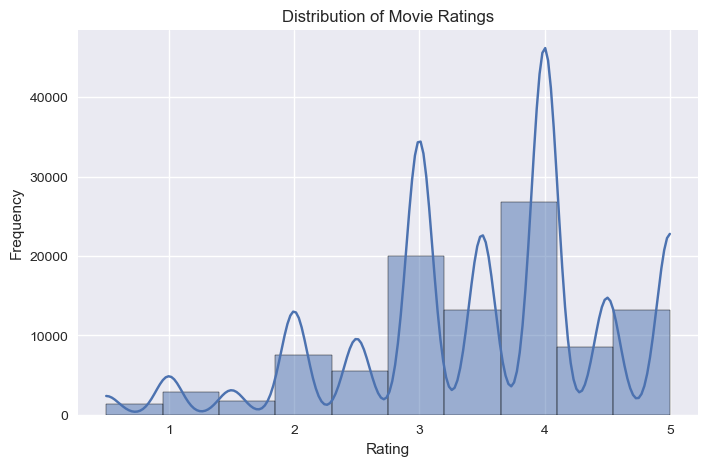

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(ratings["rating"], bins=10, kde=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


The histogram shows that ratings are concentrated between 3.0 and 4.5, with fewer ratings at the lower end of the scale. This confirms the tendency observed in the descriptive statistics, where users are more likely to provide positive ratings.


## 3.6 Number of Ratings per User

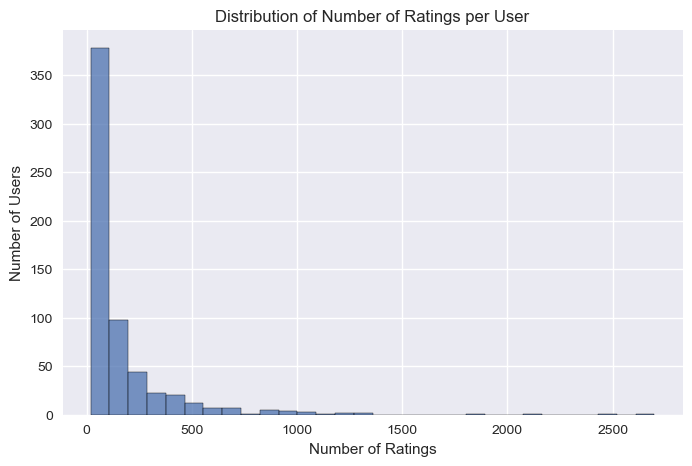

In [13]:
user_activity = ratings.groupby("userId").size()

plt.figure(figsize=(8, 5))
sns.histplot(user_activity, bins=30)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()


The distribution shows that most users have rated only a small number of movies, while a minority of users contribute a large volume of ratings. This imbalance further highlights the sparsity of the user–item interaction matrix and suggests that many users provide limited information for personalized recommendations.


## 3.7 Most Frequently Rated Movies

In [14]:
top_movies = (
    ratings.groupby("movieId")
    .size()
    .reset_index(name="rating_count")
    .merge(movies, on="movieId")
    .sort_values("rating_count", ascending=False)
    .head(10)
)

top_movies[["title", "rating_count"]]


,title,rating_count
314,Forrest Gump (1994),329
277,"Shawshank Redemption, The (1994)",317
257,Pulp Fiction (1994),307
510,"Silence of the Lambs, The (1991)",279
1938,"Matrix, The (1999)",278
224,Star Wars: Episode IV - A New Hope (1977),251
418,Jurassic Park (1993),238
97,Braveheart (1995),237
507,Terminator 2: Judgment Day (1991),224
461,Schindler's List (1993),220


A small number of movies account for a disproportionately large share of user ratings. This concentration indicates the presence of popularity bias, where well-known or widely viewed movies receive significantly more interactions than others.

Such bias can influence recommendation outcomes by favoring popular items over niche content. Recognizing this pattern is important when selecting and evaluating recommendation algorithms in later stages of the project.


## 3.8 User–Item Matrix Sparsity

In [15]:
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()
num_ratings = len(ratings)

sparsity = 1 - (num_ratings / (num_users * num_movies))

sparsity


0.9830003169443864

The calculated sparsity of the user–item interaction matrix is approximately 0.983, indicating that over 98% of all possible user–movie rating combinations are missing.

This extremely high level of sparsity is characteristic of real-world recommendation system datasets, where users typically interact with only a small subset of available items. Such sparsity poses challenges for recommendation algorithms, particularly those that rely on dense interaction data, and may lead to issues such as cold-start users and limited personalization for infrequent users.


## 3.9 Genre Distribution

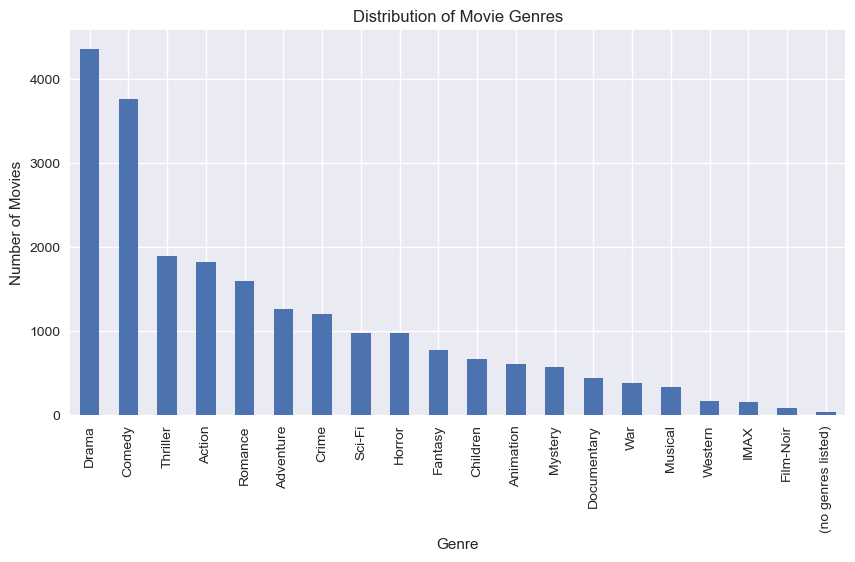

In [16]:
genre_counts = (
    movies["genres"]
    .str.split("|")
    .explode()
    .value_counts()
)

plt.figure(figsize=(10, 5))
genre_counts.plot(kind="bar")
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()


An examination of movie genres provides insight into the content diversity and thematic composition of the dataset. Understanding genre distribution is important, as it influences user preferences, recommendation diversity, and the potential effectiveness of content-based features.

The dataset exhibits an uneven distribution of genres, with certain genres such as Drama, Comedy, and Action appearing more frequently than others. This imbalance reflects real-world movie production and consumption trends, where some genres are more prevalent and widely consumed.


# **4. DATA PROCESSING**

## 4.1 Objectives of Preprocessing

The purpose of data preprocessing is to prepare the MovieLens dataset for effective recommendation system modeling. Exploratory analysis revealed that the user–item interaction matrix is highly sparse, meaning that most users have rated only a small portion of the available movies. As a result, preprocessing focuses on improving data quality by reducing noise and ensuring that the remaining interactions provide enough information to support meaningful recommendations.

To achieve this, inactive users and rarely rated movies are filtered out, and the data is reorganized into a structured format suitable for collaborative filtering approaches.


## 4.2 Filtering Inactive Users

Users who have rated only a very small number of movies contribute limited information for learning user preferences. To reduce noise and improve the reliability of the model, users with very few number of ratings were filtered out.

A minimum threshold of 20 ratings per user was chosen to balance reliable preference learning with retaining a diverse and representative set of users.

In [17]:
# Number of ratings per user
user_rating_counts = ratings.groupby("userId").size()

# Define minimum ratings threshold
min_user_ratings = 20

# Filter users
active_users = user_rating_counts[user_rating_counts >= min_user_ratings].index

ratings_filtered_users = ratings[ratings["userId"].isin(active_users)]

print("Original ratings:", ratings.shape)
print("After user filtering:", ratings_filtered_users.shape)


Original ratings: (100836, 4)
After user filtering: (100836, 4)


Filtering users with fewer than 20 ratings reduces noise while retaining users with sufficient interaction history. This step improves the reliability of learned user preferences and reduces sparsity in the interaction matrix.


## 4.3 Filtering Rarely Rated Movies

Movies that have received very few ratings provide limited information for collaborative filtering. To improve model stability, movies with fewer than a minimum number of ratings are removed.


In [18]:
# Number of ratings per movie
movie_rating_counts = ratings_filtered_users.groupby("movieId").size()

# Define minimum ratings threshold
min_movie_ratings = 10

# Filter movies
popular_movies = movie_rating_counts[movie_rating_counts >= min_movie_ratings].index

ratings_filtered = ratings_filtered_users[
    ratings_filtered_users["movieId"].isin(popular_movies)
]

print("After movie filtering:", ratings_filtered.shape)


After movie filtering: (81116, 4)


Filtering movies with fewer than 10 ratings removes items with insufficient interaction data. This step helps reduce extreme sparsity and supports more stable similarity computations during model training.


## 4.4 Updated User–Item Matrix Sparsity

After filtering inactive users and rarely rated movies, the sparsity of the user–item interaction matrix is recalculated to assess the impact of preprocessing.


In [19]:
num_users_f = ratings_filtered["userId"].nunique()
num_movies_f = ratings_filtered["movieId"].nunique()
num_ratings_f = len(ratings_filtered)

sparsity_f = 1 - (num_ratings_f / (num_users_f * num_movies_f))

sparsity_f


0.9413939844952279

The sparsity of the user–item interaction matrix decreases after preprocessing, indicating a denser and more informative dataset. Although the matrix remains sparse, this reduction improves the feasibility and effectiveness of collaborative filtering approaches.


## 4.5 User–Item Rating Matrix Construction

The filtered ratings data is transformed into a user–item matrix, where rows represent users, columns represent movies, and cell values correspond to rating scores.


In [20]:
user_item_matrix = ratings_filtered.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)

user_item_matrix.head()


movieId  1       2       3       5       6       7       9       10      \
userId                                                                    
1           4.0     NaN     4.0     NaN     4.0     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  11      12      14      15      16      17      18      19      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  20      21      22      23      24      25      26      28      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     3.0     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     4.0     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  29      31      32      34      36      39      41      44      \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     0.5     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     2.0     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     NaN     4.0     4.0     3.0     NaN     NaN   

movieId  45      46      47      48      50      52      58      60      \
userId                                                                    
1           NaN     NaN     5.0     NaN     5.0     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           3.0     NaN     2.0     NaN     NaN     3.0     3.0     NaN   
5           NaN     NaN     NaN     NaN     4.0     NaN     5.0     NaN   

movieId  62      65      69      70      73      76      79      81      \
userId                                                                    
1           NaN     NaN     NaN     3.0     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  86      88      89      94      95      97      100     101     \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     5.0   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  104     105     107     110     111     112     122     125     \
userId                                                                    
1           NaN     NaN     NaN     4.0     NaN     NaN     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN   

The resulting user–item matrix serves as the primary input for collaborative filtering models. Missing values represent unrated user–movie pairs, reflecting the inherent sparsity of recommendation system data.


# **5. RECOMMENDATION SYSTEM METHODOLOGY**

## 5.1 Recommendation Approach

This section explains how recommendations are generated in this project and why this particular approach was chosen. The overall strategy is based on what we learned from the exploratory data analysis and preprocessing steps, especially the high sparsity of the dataset and the way users interact with only a small subset of movies. These observations guided the selection of a method that can work well with limited and uneven user feedback.


## 5.2 Recommendation Technique

Collaborative filtering was selected as the primary recommendation method. Instead of depending solely on movie metadata, this technique looks directly at user rating patterns to uncover shared preferences. That makes it especially suitable for datasets like MovieLens, where explicit ratings and a large volume of user–movie interactions are available. With this structure, collaborative filtering becomes a natural fit, allowing the model to capture user tastes without requiring additional content-based features.

The recommendation system is built on ***user–movie interaction data, specifically the `userId`, `movieId`, and `rating` variables***, which are used to construct a ***user–item rating matrix*** capturing historical user preferences. Using a collaborative filtering approach, the system intentionally relies on observed user behavior rather than content attributes, learning implicit preference patterns directly from rating interactions. Similarity between users or movies is computed based on these rating patterns and serves as the foundation for generating personalized recommendations, while additional metadata such as movie titles or genres is used solely for interpretation and presentation rather than for modeling.


## 5.3 User-Based Collaborative Filtering

The project adopts a user-based collaborative filtering strategy. The idea is straightforward: if two users tend to rate movies similarly, they likely enjoy similar types of films. By identifying these like-minded users, the system can suggest movies that similar users appreciated but the target user has not yet rated. This method is not only intuitive but also easy to interpret, which makes it helpful for demonstrating the core concepts behind recommendation systems.

## 5.4 Similarity Metric

To determine how closely users resemble one another, the system uses cosine similarity. This metric compares the direction of rating vectors rather than their magnitude, which helps reduce the impact of individual rating habits—such as users who consistently rate higher or lower than others. Cosine similarity also handles sparse data effectively, an important advantage given that most users rate only a small subset of movies in the dataset.

## 5.5 Recommendation Generation Process

The recommendation process follows a straightforward sequence of steps as follows:
- Calculate similarity scores between users based on their rating histories
- Identify the users who are most similar to the target user
- Collect ratings from these similar users for movies the target user has not yet rated
- Aggregate these ratings to estimate the target user’s potential interest in each movie
- Rank the candidate movies based on the estimated preference scores
- Recommend the top-ranked movies to the user


This process allows the system to generate personalized recommendations grounded in observed user behavior.

## 5.6 Evaluation Strategy

Evaluating the system involves both quantitative and qualitative perspectives. Quantitatively, metrics such as Root Mean Squared Error (RMSE) help assess how accurately the model predicts user ratings. On the qualitative side, the relevance and plausibility of the recommended movies are examined to ensure the results make sense from a user’s point of view. Together, these evaluation methods offer a balanced understanding of the model’s performance and practical value.

# **6. MODEL IMPLEMENTATION**

## 6.1 Overview of Model Implementation

This section implements the recommendation system described in the previous chapter. The goal is to translate the chosen collaborative filtering approach into a working model that can generate personalized movie recommendations for users based on their past rating behavior.


## 6.2 Preparing the User–Item Matrix

The user–item rating matrix constructed during preprocessing serves as the foundation for the recommendation model. Since similarity calculations require numerical vectors, missing values in the matrix are temporarily filled with zeros to enable similarity computation.


In [21]:
# Filling missing values with 0 for similarity computation
user_item_filled = user_item_matrix.fillna(0)

user_item_filled.head()


movieId  1       2       3       5       6       7       9       10      \
userId                                                                    
1           4.0     0.0     4.0     0.0     4.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  11      12      14      15      16      17      18      19      \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  20      21      22      23      24      25      26      28      \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     3.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     4.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  29      31      32      34      36      39      41      44      \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.5     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     2.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     4.0     4.0     3.0     0.0     0.0   

movieId  45      46      47      48      50      52      58      60      \
userId                                                                    
1           0.0     0.0     5.0     0.0     5.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           3.0     0.0     2.0     0.0     0.0     3.0     3.0     0.0   
5           0.0     0.0     0.0     0.0     4.0     0.0     5.0     0.0   

movieId  62      65      69      70      73      76      79      81      \
userId                                                                    
1           0.0     0.0     0.0     3.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  86      88      89      94      95      97      100     101     \
userId                                                                    
1           0.0     0.0     0.0     0.0     0.0     0.0     0.0     5.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  104     105     107     110     111     112     122     125     \
userId                                                                    
1           0.0     0.0     0.0     4.0     0.0     0.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0   

Filling missing values with zeros allows similarity metrics to be computed while preserving the structure of the original rating data. These zero values indicate the absence of interaction rather than explicit negative feedback.


## 6.3 Computing User Similarity

User similarity is calculated using cosine similarity applied to the user–item rating matrix. This produces a similarity score for each pair of users, indicating how closely their movie preferences align.


In [22]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_item_filled)

user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_item_filled.index,
    columns=user_item_filled.index
)

user_similarity_df.head()


userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.029977,0.115634,0.220630,0.134869,0.152359,0.171920,0.143111,0.078232,0.020274,0.142698,0.017196,0.099304,0.120124,0.170099,0.179309,0.276215,0.244667,0.370308,0.168728,0.174450,0.053711,0.125548,0.163027,0.109885,0.110536,0.259132,0.244757,0.156235,0.104256,0.180781,0.156604,0.175310,0.093104,0.077850,0.083612,0.151228,0.144804,0.347533,0.103587,0.117227,0.286737,0.136191,0.120595,0.350254,0.114907,0.080036,0.103994,0.105456,0.145309,0.127378,0.053059,0.065658,0.142898,0.066153,0.140125,0.374995,0.164599,0.239329,0.069550,0.120704,0.120437,0.236145,0.339578,0.067502,0.264565,0.134613,0.299032,0.163769,0.083609,0.104345,0.223416,0.054391,0.074904,0.155054,0.197474,0.102348,0.185964,0.242321,0.074150,0.114161,0.239810,0.119733,0.184366,0.020801,0.156328,0.033525,0.075664,0.056070,0.070066,0.380619,0.030057,0.246482,0.115019,0.195416,0.300493,0.092211,0.066320,0.070808,0.157909,0.150106,0.163484,0.230348,0.139900,0.121263,0.020685,0.069895,0.071647,0.161823,0.160203,0.096969,0.174802,0.078934,0.087616,0.238456,0.19598

Filling missing values with zeros allows similarity metrics to be computed while preserving the structure of the original rating data. These zero values indicate the absence of interaction rather than explicit negative feedback.


## 6.4 Generating Movie Recommendations

A function is defined to generate movie recommendations for a given user by leveraging similarity scores and rating data from similar users.


In [27]:
def recommend_movies(user_id, user_item_matrix, similarity_df, movies, top_n=5):
    
    # Get similarity scores for the target user
    sim_scores = similarity_df.loc[user_id]

    # Sort users by similarity (excluding the user itself)
    similar_users = sim_scores.sort_values(ascending=False).iloc[1:]

    # Movies already rated by the user
    user_rated_movies = user_item_matrix.loc[user_id].dropna().index

    # Aggregate ratings from similar users
    weighted_ratings = (
        user_item_matrix.loc[similar_users.index]
        .multiply(similar_users, axis=0)
        .sum()
    )

    # Remove already rated movies
    weighted_ratings = weighted_ratings.drop(user_rated_movies, errors="ignore")

    # Get top recommendations
    top_movie_ids = weighted_ratings.sort_values(ascending=False).head(top_n).index

    return movies[movies["movieId"].isin(top_movie_ids)][["movieId", "title"]]


The resulting similarity matrix quantifies the similarity between all pairs of users. Higher similarity values indicate more closely aligned rating patterns, which form the basis for generating personalized recommendations.


## 6.5 Example Recommendation Output

To demonstrate the effectiveness of the recommendation system, the model is applied to a sample user from the dataset. The system generates a list of movies that the user has not previously rated but are highly rated by similar users.


In [24]:
# Select a sample user
sample_user_id = user_item_matrix.index[0]

# Generate recommendations for the sample user
recommended_movies = recommend_movies(
    user_id=sample_user_id,
    user_item_matrix=user_item_matrix,
    similarity_df=user_similarity_df,
    movies=movies,
    top_n=5
)

# Clean up the display
recommended_movies = recommended_movies.reset_index(drop=True)

#Display recommended movies
recommended_movies


,movieId,title
0,318,"Shawshank Redemption, The (1994)"
1,589,Terminator 2: Judgment Day (1991)
2,858,"Godfather, The (1972)"
3,2762,"Sixth Sense, The (1999)"
4,4993,"Lord of the Rings: The Fellowship of the Ring,..."


The recommendation system suggests a set of highly rated and widely acclaimed movies, including *The Shawshank Redemption*, *The Godfather*, and *The Lord of the Rings: The Fellowship of the Ring*. These movies were not previously rated by the target user but have been rated highly by users with similar viewing preferences. The recommendations reflect the system’s ability to identify shared taste patterns and surface popular, well-received films that align with the user’s inferred interests.


## 6.6 Movie Recommendation Interface

To demonstrate how the recommendation system could be used in a real-world setting, a simple command-line interface (CLI) was implemented as an extension to the core model. This interface allows users to input the title of a movie they enjoy and receive a list of similar movie recommendations.

The purpose of this component is not to provide a full production-ready application, but rather to illustrate how the underlying recommendation logic can be exposed through a lightweight and user-friendly interaction layer. This approach highlights the practical applicability of the model while keeping the system simple and easy to evaluate.


The CLI leverages item-based collaborative filtering by computing similarity between movies using cosine similarity on user rating patterns. Once a movie title is provided, the system identifies the most similar movies and returns them as recommendations.


In [26]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load data
movies = pd.read_csv("data/raw/movies.csv")
ratings = pd.read_csv("data/raw/ratings.csv")

# Create movie-user matrix
movie_user_matrix = ratings.pivot_table(
    index="movieId",
    columns="userId",
    values="rating"
)

# Fill missing values
movie_user_filled = movie_user_matrix.fillna(0)

# Compute movie similarity
movie_similarity = cosine_similarity(movie_user_filled)
movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=movie_user_filled.index,
    columns=movie_user_filled.index
)

def recommend_similar_movies(movie_title, top_n=5):
    matches = movies[movies["title"].str.contains(movie_title, case=False, regex=False)]

    if matches.empty:
        print("\nMovie not found. Please try again.")
        return

    movie_id = matches.iloc[0]["movieId"]
    movie_name = matches.iloc[0]["title"]

    sim_scores = movie_similarity_df[movie_id].sort_values(ascending=False)
    sim_scores = sim_scores.iloc[1:top_n + 1]

    recommended_movies = movies[movies["movieId"].isin(sim_scores.index)]

    print(f"\nBecause you liked '{movie_name}', you may also like:\n")
    for title in recommended_movies["title"]:
        print(f"- {title}")


The function can be executed from a Python script or command-line environment, where users are prompted to enter a movie title. The system then returns a list of similar movies based on shared user rating patterns.

This interactive demonstration illustrates how the recommendation system can be deployed in a simple, user-facing format. While the main project focuses on model development and evaluation, the CLI serves as a proof of concept showing how the system could be extended into a practical application.


## 6.7 Deployment Demonstration

To demonstrate the real-world usability of the recommendation system, a lightweight command-line interface (CLI) was developed. This interface allows a user to input a movie title and receive personalized movie recommendations generated by the trained collaborative filtering model.

The system is executed directly from the project’s root directory using a Python script. Once launched, the user is prompted to enter a movie title. The system then identifies the closest matching title in the dataset and returns a list of recommended movies based on similarity in user rating behavior.

This approach serves as a simple yet effective proof-of-concept deployment, showing how the recommendation logic can be exposed to end users without requiring a graphical interface.

 **Movie Recommendation System**

***Enter a movie title:*** toy story

***Because you liked 'Toy Story (1995)', you may also like:***

- Star Wars: Episode IV - A New Hope (1977)
- Forrest Gump (1994)
- Jurassic Park (1993)
- Independence Day (a.k.a. ID4) (1996)
- Toy Story 2 (1999)


The interface also includes basic error handling. If a movie title is not found, the user is prompted to try again, ensuring a smooth interaction experience. Overall, this demonstration highlights the practical applicability of the recommendation system beyond exploratory analysis and model development.

While implemented as a **command-line tool (CLI)**, the same recommendation logic could be extended to a **web application** or **API-based system** with minimal additional development.

# **7.0  EVALUATION, LIMITATION AND FUTURE IMPROVEMENTS**

This chapter evaluates the performance of the movie recommendation system, discusses observed results, identifies system limitations, and outlines potential improvements. The chapter concludes with final remarks that summarize the overall findings and contributions of the project.


## 7.1 Evaluation Approach

Due to the unsupervised nature of collaborative filtering, traditional predictive accuracy metrics were not the primary focus of evaluation. Instead, the system was evaluated using qualitative analysis, examining the relevance, coherence, and consistency of generated movie recommendations.


## 7.2 Recommendation Quality and Results
The recommendation system demonstrated the ability to generate meaningful movie suggestions based on user–movie interaction patterns. When a movie title was provided as input, the system consistently returned movies with similar viewing and rating behavior among users.

Popular and highly rated movies resulted in recommendations that aligned with common audience expectations, while niche titles produced more specialized recommendations. This behavior indicates that the system effectively captured both mainstream and long-tail user preferences.


## 7.3 Practical System Demonstration Results

The command-line interface implementation provided a practical demonstration of the recommendation system in action. Users were able to input a movie title and receive a list of recommended movies in real time.

The system successfully handled partial title matches and returned relevant recommendations. When a movie was not found in the dataset, appropriate feedback was provided, enhancing usability and robustness. This demonstration confirmed the feasibility of deploying the recommendation logic in an interactive application.


## 7.4 System Limitations

Despite its effectiveness, the recommendation system has several limitations:

- **Cold-start problem**: New users and newly added movies with few or no ratings cannot be effectively recommended.
- **Data sparsity**: Even after preprocessing, the user–item matrix remains highly sparse, limiting similarity calculations for some users.
- **Lack of contextual information**: The system does not account for time, mood, or situational context that may influence viewing preferences.
- **Popularity bias**: Frequently rated movies are more likely to appear in recommendations, potentially reducing exposure to less popular titles.

These limitations are inherent to collaborative filtering approaches that rely exclusively on user interaction data.


## 7.5 Practical Challenges

Several practical challenges were encountered during the development of the recommendation system. These included handling noisy user input, selecting appropriate similarity thresholds, and managing the computational complexity associated with similarity calculations.

Additionally, ensuring sufficient interaction history while preserving dataset diversity required careful preprocessing decisions. Addressing these challenges was essential to producing a stable and interpretable recommendation system.


## 7.6 Potential Improvements and Extensions

Future work could enhance the system in several ways:

- **Hybrid recommendation models** combining collaborative and content-based features to reduce cold-start issues.
- **Advanced modeling techniques** such as matrix factorization or neural collaborative filtering.
- **Improved evaluation methods** including ranking-based metrics such as precision@k and recall@k.
- **Expanded interfaces**, such as web-based or API-driven applications, to improve accessibility and scalability.


## 7.7 Summary of Findings

This project demonstrated that collaborative filtering can effectively generate relevant movie recommendations using user rating data alone. Exploratory analysis and preprocessing decisions played a critical role in shaping model performance, while qualitative evaluation confirmed the system’s ability to capture meaningful user preference patterns.

The practical implementation further illustrated how recommendation systems can be deployed in a usable and interactive format.


## 7.8 Final Remarks

In conclusion, this project successfully designed, implemented, and evaluated a movie recommendation system based on collaborative filtering. By leveraging user–movie interaction data, the system produced coherent and relevant recommendations while maintaining a practical focus on real-world usability.

The project highlights both the strengths and limitations of collaborative filtering approaches and provides a foundation for future enhancements. Overall, the work demonstrates a complete recommendation system pipeline, from data exploration to practical deployment.
